# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [879]:
n_samples = 10000

In [880]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, best=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if best is not None:
        plt.scatter(best['x'], best['y'], color='red', marker='*', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [881]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

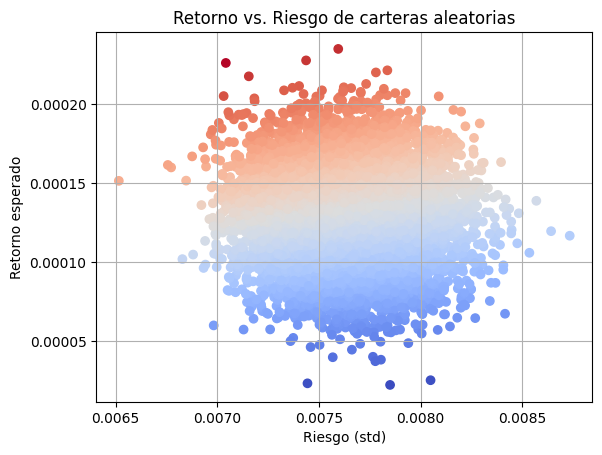

In [882]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset36', 'asset8', 'asset34', 'asset42', 'asset28', 'asset4', 'asset16', 'asset1', 'asset21', 'asset22', 'asset37', 'asset31', 'asset2', 'asset39', 'asset35', 'asset27', 'asset29', 'asset41', 'asset15', 'asset18', 'asset20', 'asset40', 'asset14'}
[35, 7, 33, 41, 27, 3, 15, 0, 20, 21, 36, 30, 1, 38, 34, 26, 28, 40, 14, 17, 19, 39, 13]


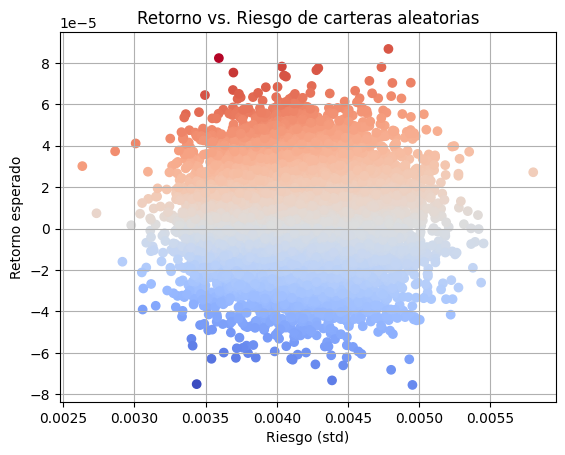

In [883]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 5):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.7) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



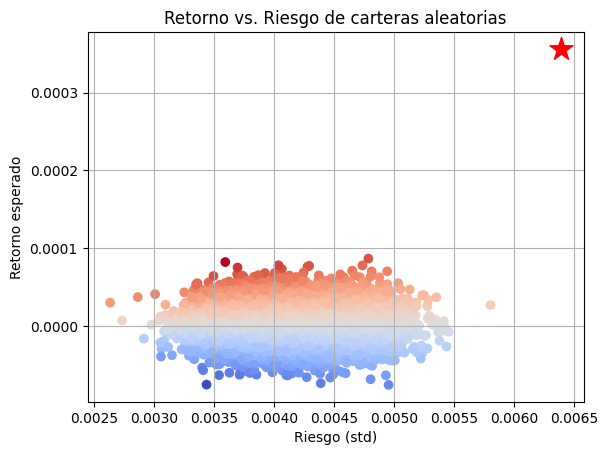

In [884]:
import cvxpy as cp

# Los assets con correlacion inferior al 70% y curtosis <= 5 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
# 2% se refiere a anual
fixed_income_return = 0.02 / 252 
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (fixed_income_return)) 


# CVXPY
target_return = cp.Parameter()
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov.values)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.1, # No invertimos mas de un 10% en cada activo (forzar diversificacion)
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0, # Evitamos dar peso a los activos muy relacionados o con curtosis alta
    portfolio_returns >= target_return # Minimo de retorno esperado
]

results = []
problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)

for r in np.linspace(fixed_income_return, returns_means.max(), 100):
    target_return.value = r

    problem.solve(solver=cp.OSQP)

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - fixed_income_return) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)

best_sharpe = portfolio_results.iloc[0]
best_sharpe_weights = best_sharpe[3:]

plot_sharpe(returns, mask, best={'x': best_sharpe['volatility'], 'y': best_sharpe['return']})


In [885]:
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
44,0.000356,0.006389,0.043313,8.138806e-09,-6.474676e-09,0.099999,-4.318308e-09,0.087714,0.099994,1.188912e-05,...,-3.176055e-09,6.564421e-06,0.099997,8.929870e-06,0.099998,5.173479e-06,5.855075e-06,1.502912e-05,0.000006,0.100002
43,0.000350,0.006252,0.043254,-1.656441e-09,1.264559e-09,0.100000,7.472811e-10,0.100000,0.100001,-2.689788e-06,...,8.876170e-10,-1.059672e-06,0.100001,-7.041261e-07,0.100001,-1.241685e-06,-1.157735e-06,-1.585054e-06,0.002958,0.100000
42,0.000344,0.006175,0.042778,-1.570954e-09,1.199285e-09,0.100000,7.087270e-10,0.100000,0.100001,-2.550994e-06,...,8.417989e-10,-1.004984e-06,0.100001,-6.677695e-07,0.100001,-1.177596e-06,-1.097988e-06,-1.503222e-06,0.009085,0.100000
45,0.000362,0.006656,0.042519,-7.379289e-09,6.571788e-09,0.100002,4.548647e-09,0.090312,0.100007,-1.078987e-05,...,4.529019e-09,-5.433760e-06,0.100004,-5.811894e-06,0.100003,-5.260271e-06,-4.977188e-06,-1.128975e-05,-0.000004,0.077563
41,0.000337,0.006100,0.042272,-1.985475e-09,8.690609e-10,0.100000,3.828875e-10,0.100000,0.100001,-2.443276e-06,...,8.742273e-10,-9.115164e-07,0.100001,1.369340e-03,0.100000,-1.715071e-06,-1.064988e-06,-5.316582e-07,0.014648,0.100001
40,0.000331,0.006027,0.041740,-1.985475e-09,8.690609e-10,0.100000,3.828875e-10,0.100000,0.100001,-2.443276e-06,...,8.742273e-10,-9.115164e-07,0.100001,1.130738e-02,0.100000,-1.715071e-06,-1.064988e-06,-5.316582e-07,0.016684,0.100001
46,0.000369,0.006945,0.041655,-5.736308e-09,6.340828e-09,0.100002,4.582367e-09,0.100001,0.100006,-8.550556e-06,...,4.044328e-09,-4.128552e-06,0.100004,-5.412566e-06,0.100003,-3.488148e-06,-3.637742e-06,-1.028491e-05,-0.000003,0.050075
39,0.000325,0.005956,0.041184,-1.985475e-09,8.690608e-10,0.100000,3.828875e-10,0.100000,0.100001,-2.443276e-06,...,8.742272e-10,-9.115163e-07,0.100001,2.124542e-02,0.100000,-1.715071e-06,-1.064988e-06,-5.316581e-07,0.018720,0.100001
47,0.000375,0.007248,0.040780,-6.688110e-09,7.392933e-09,0.100003,5.342698e-09,0.100001,0.100007,-9.969315e-06,...,4.715385e-09,-4.813586e-06,0.100004,-6.310650e-06,0.100003,-4.066923e-06,-4.241338e-06,-1.199144e-05,-0.000004,0.028550
38,0.000318,0.005886,0.040604,-1.985395e-09,8.690219e-10,0.100000,3.828701e-10,0.100000,0.100001,-2.443178e-06,...,8.741889e-10,-9.114800e-07,0.100001,3.118346e-02,0.100000,-1.715002e-06,-1.064946e-06,-5.316338e-07,0.020756,0.100001


In [886]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [887]:
# rounded_weights = round_weights(best_sharpe_weights.tolist())
rounded_weights = np.array([round(w, 3) if abs(w) > 1e-4 else 0.0 for w in best_sharpe_weights])
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(len(rounded_weights[rounded_weights > 0]))

['0', '0', '0.1', '0', '0.088', '0.1', '0', '0', '0.1', '0', '0', '0.1', '0.1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.012', '0', '0', '0', '0', '0', '0.1', '0', '0.1', '0', '0', '0', '0', '0.1']
11


In [888]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.02/252

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.006880636548929119


In [889]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")

Max Drawdown: -16.85%
